# Jupyter backend demo: molecular viewer in the notebook

This example shows how vispy's low-level gloo interface can be used to display a VisPy Canvas in a notebook. The higher level Scene and Plotting API are also supported. By default, vispy will detect that it is being run in a notebook and load the "jupyter_rfb" backend automatically. This does require that the "jupyter_rfb" package be installed.

Due to the way widgets work in Jupyter, you can display the Canvas multiple times, but they will continue to represent the same object. In the case of timers, they will continue to run in the backgroudn until they are stopped, even if the output of your notebook cell is cleared and no canvas is visible.

In [9]:
import numpy as np

from vispy import gloo
from vispy import app
from vispy.util.transforms import perspective, translate, rotate
from vispy.io import load_data_file

In [10]:
vertex = """
#version 120

uniform mat4 u_model;
uniform mat4 u_view;
uniform mat4 u_projection;
uniform vec3 u_light_position;
uniform vec3 u_light_spec_position;

attribute vec3  a_position;
attribute vec3  a_color;
attribute float a_radius;

varying vec3  v_color;
varying vec4  v_eye_position;
varying float v_radius;
varying vec3  v_light_direction;

void main (void) {
    v_radius = a_radius;
    v_color = a_color;

    v_eye_position = u_view * u_model * vec4(a_position,1.0);
    v_light_direction = normalize(u_light_position);
    float dist = length(v_eye_position.xyz);

    gl_Position = u_projection * v_eye_position;

    // stackoverflow.com/questions/8608844/...
    //  ... resizing-point-sprites-based-on-distance-from-the-camera
    vec4  proj_corner = u_projection * vec4(a_radius, a_radius, v_eye_position.z, v_eye_position.w);  // # noqa
    gl_PointSize = 512.0 * proj_corner.x / proj_corner.w;
}
"""

fragment = """
#version 120

uniform mat4 u_model;
uniform mat4 u_view;
uniform mat4 u_projection;
uniform vec3 u_light_position;
uniform vec3 u_light_spec_position;

varying vec3  v_color;
varying vec4  v_eye_position;
varying float v_radius;
varying vec3  v_light_direction;
void main()
{
    // r^2 = (x - x0)^2 + (y - y0)^2 + (z - z0)^2
    vec2 texcoord = gl_PointCoord* 2.0 - vec2(1.0);
    float x = texcoord.x;
    float y = texcoord.y;
    float d = 1.0 - x*x - y*y;
    if (d <= 0.0)
        discard;

    float z = sqrt(d);
    vec4 pos = v_eye_position;
    pos.z += v_radius*z;
    vec3 pos2 = pos.xyz;
    pos = u_projection * pos;
    //gl_FragDepth = 0.5*(pos.z / pos.w)+0.5;
    vec3 normal = vec3(x,y,z);
    float diffuse = clamp(dot(normal, v_light_direction), 0.0, 1.0);

    // Specular lighting.
    vec3 M = pos2.xyz;
    vec3 O = v_eye_position.xyz;
    vec3 L = u_light_spec_position;
    vec3 K = normalize(normalize(L - M) + normalize(O - M));
    // WARNING: abs() is necessary, otherwise weird bugs may appear with some
    // GPU drivers...
    float specular = clamp(pow(abs(dot(normal, K)), 40.), 0.0, 1.0);
    vec3 v_light = vec3(1., 1., 1.);
    gl_FragColor.rgba = vec4(.15*v_color + .55*diffuse * v_color
                        + .35*specular * v_light, 1.0);
}
"""

In [11]:
class Canvas(app.Canvas):

    def __init__(self):
        app.Canvas.__init__(self, title='Molecular viewer',
                            keys='interactive', size=(640, 480))
        self.ps = self.pixel_scale

        self.translate = 40
        self.program = gloo.Program(vertex, fragment)
        self.view = translate((0, 0, -self.translate))
        self.model = np.eye(4, dtype=np.float32)
        self.projection = np.eye(4, dtype=np.float32)

        self.apply_zoom()

        fname = load_data_file('molecular_viewer/micelle.npz')
        self.load_molecule(fname)
        self.load_data()

        self.theta = 0
        self.phi = 0

        gloo.set_state(depth_test=True, clear_color='black')
        self.timer = app.Timer('auto', connect=self.on_timer, start=True)

        self.show()

    def load_molecule(self, fname):
        molecule = np.load(fname)['molecule']
        self._nAtoms = molecule.shape[0]

        # The x,y,z values store in one array
        self.coords = molecule[:, :3]

        # The array that will store the color and alpha scale for all the atoms
        self.atomsColours = molecule[:, 3:6]

        # The array that will store the scale for all the atoms.
        self.atomsScales = molecule[:, 6]

    def load_data(self):
        n = self._nAtoms

        data = np.zeros(n, [('a_position', np.float32, 3),
                            ('a_color', np.float32, 3),
                            ('a_radius', np.float32)])

        data['a_position'] = self.coords
        data['a_color'] = self.atomsColours
        data['a_radius'] = self.atomsScales*self.ps

        self.program.bind(gloo.VertexBuffer(data))

        self.program['u_model'] = self.model
        self.program['u_view'] = self.view
        self.program['u_light_position'] = 0., 0., 2.
        self.program['u_light_spec_position'] = -5., 5., -5.

    def on_key_press(self, event):
        if event.text == ' ':
            if self.timer.running:
                self.timer.stop()
            else:
                self.timer.start()

    def on_timer(self, event):
        self.theta += .25
        self.phi += .25
        self.model = np.dot(rotate(self.theta, (0, 0, 1)),
                            rotate(self.phi, (0, 1, 0)))
        self.program['u_model'] = self.model
        self.update()

    def on_resize(self, event):
        width, height = event.physical_size
        gloo.set_viewport(0, 0, width, height)
        self.projection = perspective(25.0, width / float(height), 2.0, 100.0)
        self.program['u_projection'] = self.projection

    def apply_zoom(self):
        width, height = self.physical_size
        gloo.set_viewport(0, 0, width, height)
        self.projection = perspective(25.0, width / float(height), 2.0, 100.0)
        self.program['u_projection'] = self.projection

    def on_mouse_wheel(self, event):
        self.translate -= event.delta[1]
        self.translate = max(-1, self.translate)
        self.view = translate((0, 0, -self.translate))

        self.program['u_view'] = self.view
        self.update()

    def on_draw(self, event):
        gloo.clear()
        self.program.draw('points')


RFBOutputContext()


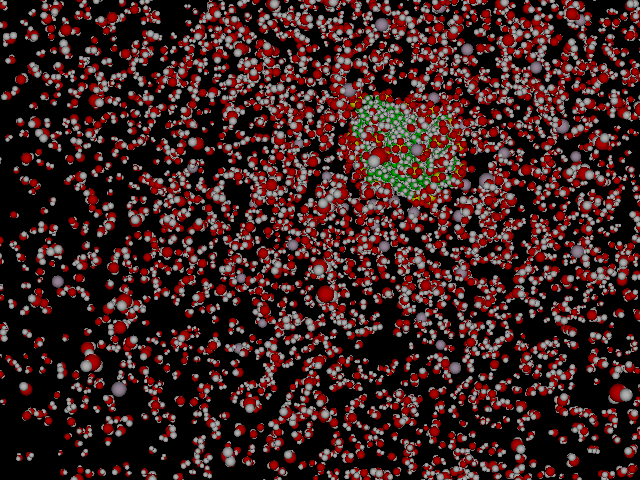

CanvasBackend(css_height='480px', css_width='640px')

In [12]:
c = Canvas()
c

To pause the rotation you can either hit the Spacebar or manually call the `stop(`)/`start()` methods on the timer:

In [13]:
# c.timer.stop()

In [14]:
# c.timer.start()